# Descripción

La compañía de seguros Sure Tomorrow quiere resolver varias tareas con la ayuda de machine learning y te pide que evalúes esa posibilidad.
- Tarea 1: encontrar clientes que sean similares a un cliente determinado. Esto ayudará a los agentes de la compañía con el marketing.
- Tarea 2: predecir la probabilidad de que un nuevo cliente reciba una prestación del seguro. ¿Puede un modelo de predictivo funcionar mejor que un modelo dummy?
- Tarea 3: predecir el número de prestaciones de seguro que un nuevo cliente pueda recibir utilizando un modelo de regresión lineal.
- Tarea 4: proteger los datos personales de los clientes sin afectar al modelo del ejercicio anterior. Es necesario desarrollar un algoritmo de transformación de datos que dificulte la recuperación de la información personal si los datos caen en manos equivocadas. Esto se denomina enmascaramiento u ofuscación de datos. Pero los datos deben protegerse de tal manera que no se vea afectada la calidad de los modelos de machine learning. No es necesario elegir el mejor modelo, basta con demostrar que el algoritmo funciona correctamente.


# Preprocesamiento y exploración de datos

## Inicialización

In [1]:
##pip install scikit-learn --upgrade

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

import seaborn as sns

import sklearn.linear_model
import sklearn.metrics
import sklearn.neighbors
import sklearn.preprocessing

from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier

from sklearn.model_selection import train_test_split

from IPython.display import display

## Carga de datos

Carga los datos y haz una revisión básica para comprobar que no hay problemas obvios.

In [3]:
df = pd.read_csv('datasets/insurance_us.csv')

Renombramos las columnas para que el código se vea más coherente con su estilo.

In [4]:
df = df.rename(columns={'Gender': 'gender', 'Age': 'age', 'Salary': 'income', 'Family members': 'family_members', 'Insurance benefits': 'insurance_benefits'})

In [5]:
df.sample(10)

,gender,age,income,family_members,insurance_benefits
1656,0,41.0,38300.0,0,0
2746,0,24.0,28100.0,2,0
1766,0,40.0,30900.0,1,0
2512,1,19.0,43200.0,1,0
2559,0,45.0,62000.0,2,1
809,1,29.0,48500.0,0,0
2227,1,43.0,45900.0,3,1
3470,1,24.0,27100.0,2,0
3706,1,38.0,37700.0,2,0
4871,1,18.0,29200.0,0,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gender              5000 non-null   int64  
 1   age                 5000 non-null   float64
 2   income              5000 non-null   float64
 3   family_members      5000 non-null   int64  
 4   insurance_benefits  5000 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


In [7]:
# puede que queramos cambiar el tipo de edad (de float a int) aunque esto no es crucial

# escribe tu conversión aquí si lo deseas:
df["age"] = df["age"].astype(int)

In [8]:
# comprueba que la conversión se haya realizado con éxito
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gender              5000 non-null   int64  
 1   age                 5000 non-null   int64  
 2   income              5000 non-null   float64
 3   family_members      5000 non-null   int64  
 4   insurance_benefits  5000 non-null   int64  
dtypes: float64(1), int64(4)
memory usage: 195.4 KB


## Estadistica Descriptiva

In [9]:
# ahora echa un vistazo a las estadísticas descriptivas de los datos.# ¿Se ve todo bien?

In [10]:
# https://gist.github.com/pb111/512c840affb32593d28573fbb764045b

### Measure of Central Tendeny

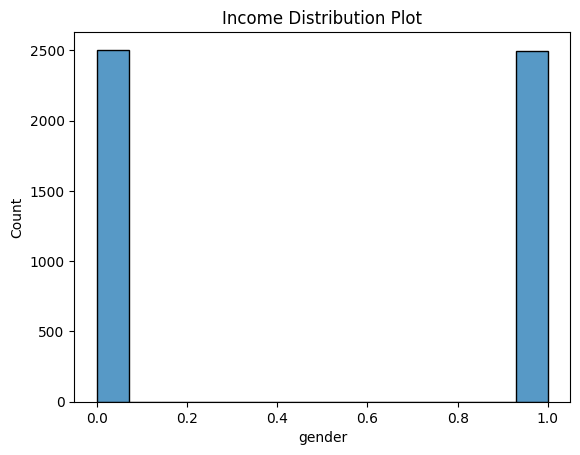

In [11]:
plt.title('Income Distribution Plot')
sns.histplot(df["gender"])
plt.show()

Vemos que las clases en el campo de genero están balanceadas. Hay representatividad equitativa para ambos generos

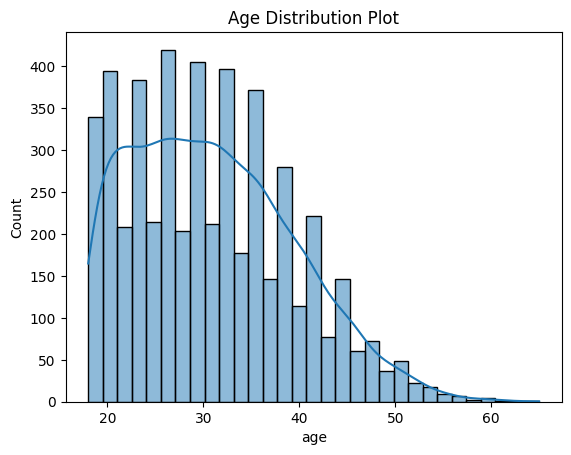

In [12]:
plt.title('Age Distribution Plot')
sns.histplot(df["age"], kde=True)
plt.show()

La curva de distribución nos muestra que hay un desvio a la derecha, lo que significa que el rango de edad se concentra mayormente entre los 20 y 40 años. Al parecer, no es comun tener clientes con edades avanzadas

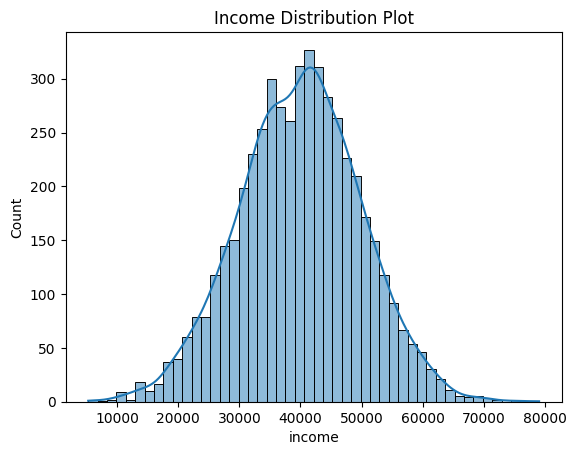

In [13]:
plt.title('Income Distribution Plot')
sns.histplot(df["income"], kde=True)
plt.show()

Encontramos una distribución normal en el ingreso de los clientes, con un rango salarial entre los 25,000 y los 55,000 (podemos pensar que se refiere al ingreso anual)

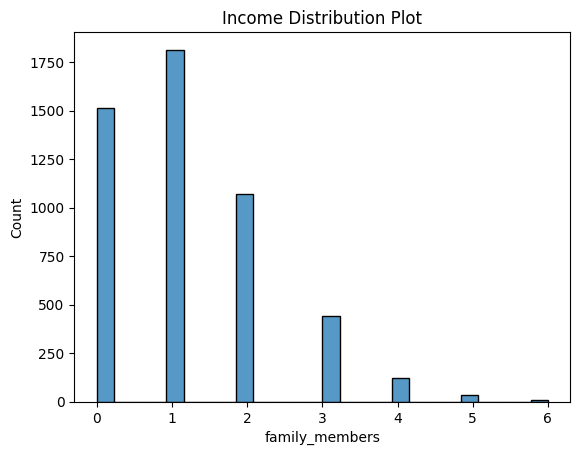

In [14]:
plt.title('Income Distribution Plot')
sns.histplot(df["family_members"])
plt.show()

La mayoría de los clientes asegurados tienen entre 0 y 2 familiares

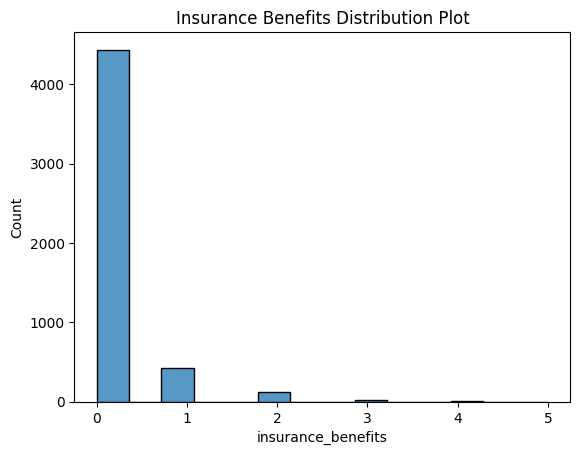

In [15]:
plt.title('Insurance Benefits Distribution Plot')
sns.histplot(df["insurance_benefits"])
plt.show()

Encontramos que la mayoría de los clientes no cuentan con beneficios por parte del seguro, lo que es un problema ya que es nuestra variable objetivo. Considero que esto nos llevará a tener que realizar un proceso de **oversampling**

## Análisis exploratorio de datos

Vamos a comprobar rápidamente si existen determinados grupos de clientes observando el gráfico de pares.

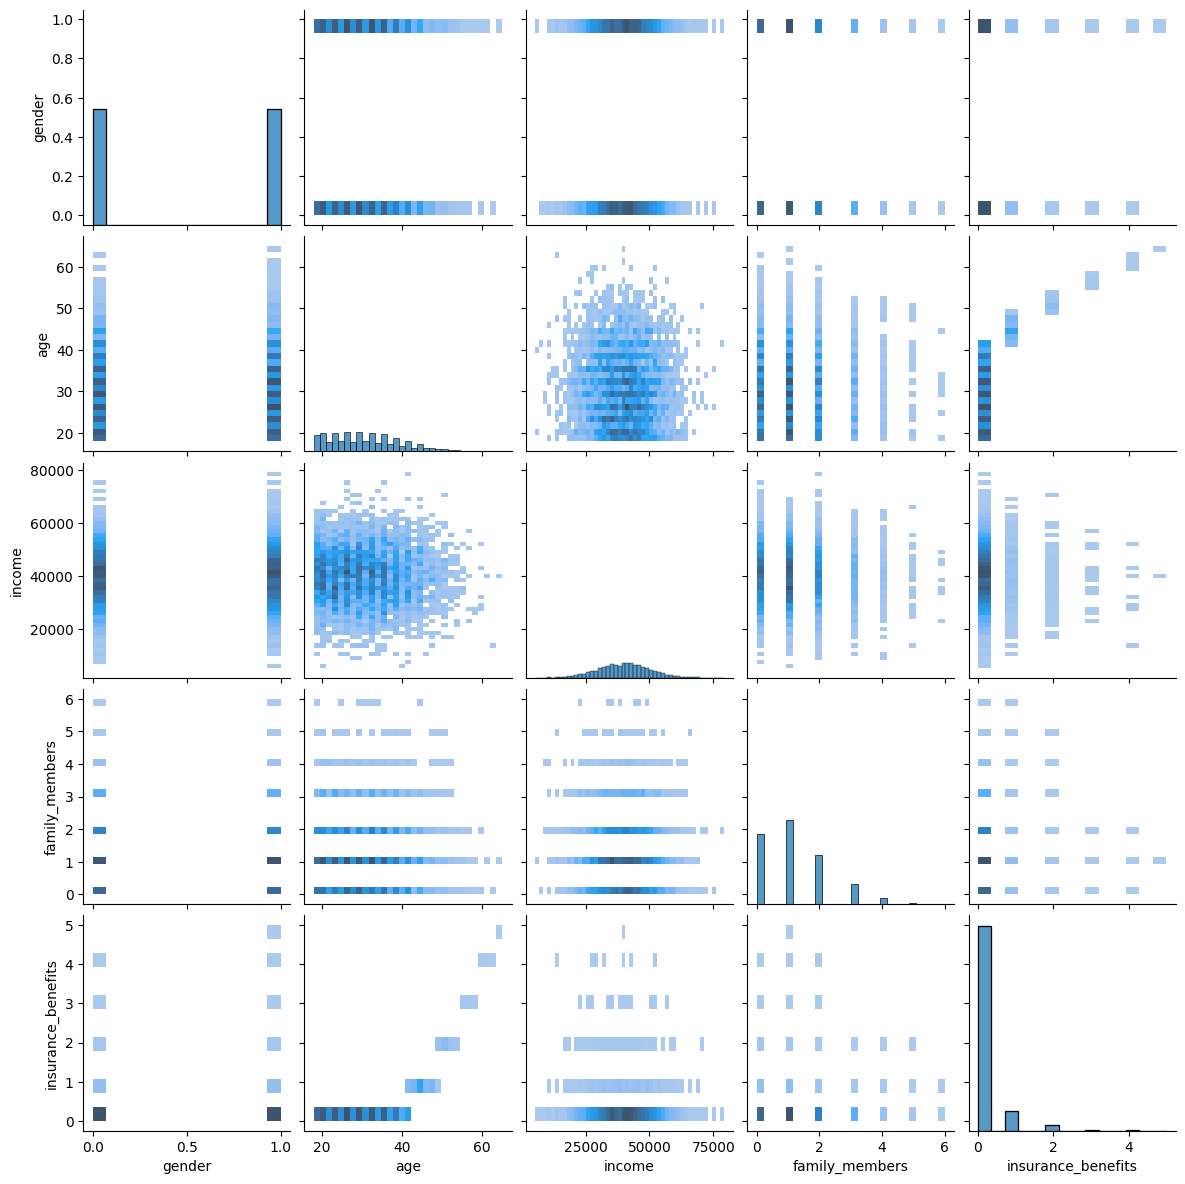

In [16]:
g = sns.pairplot(df, kind='hist')
g.fig.set_size_inches(12, 12)

De acuerdo, es un poco complicado detectar grupos obvios (clústeres) ya que es difícil combinar diversas variables simultáneamente (para analizar distribuciones multivariadas). Ahí es donde LA y ML pueden ser bastante útiles.

Aún así podemos decir que los graficos de dispercion no muestran una correlacion entre las variables.

### Matriz de Coorelacion

<Axes: >

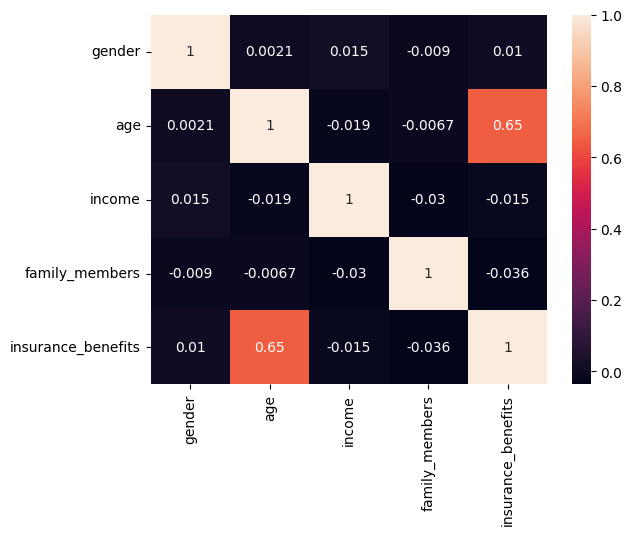

In [17]:
correlation_mtx =df.loc[:,["gender","age","income","family_members","insurance_benefits"]].corr()
sns.heatmap(correlation_mtx,annot=True)

Nos encontramos que la variable age tiene una correlacion muy alta con nuestra variable objetivo. Esto significa que debemos eliminar la caracteristica de edad para aquellos modelos en los que se usa la variable objetivo (insurance_benefits) si queremos mantener un modelo eficiente, que no prediga un resultado sesgado por la edad del cliente en el sample.

# Tarea 1. Clientes similares

En el lenguaje de ML, es necesario desarrollar un procedimiento que devuelva los k vecinos más cercanos (objetos) para un objeto dado basándose en la distancia entre los objetos.
Es posible que quieras revisar las siguientes lecciones (capítulo -> lección)- Distancia entre vectores -> Distancia euclidiana
- Distancia entre vectores -> Distancia Manhattan

Para resolver la tarea, podemos probar diferentes métricas de distancia.

Escribe una función que devuelva los k vecinos más cercanos para un $n^{th}$ objeto basándose en una métrica de distancia especificada. A la hora de realizar esta tarea no debe tenerse en cuenta el número de prestaciones de seguro recibidas.
Puedes utilizar una implementación ya existente del algoritmo kNN de scikit-learn (consulta [el enlace](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html#sklearn.neighbors.NearestNeighbors)) o tu propia implementación.
Pruébalo para cuatro combinaciones de dos casos- Escalado
  - los datos no están escalados
  - los datos se escalan con el escalador [MaxAbsScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MaxAbsScaler.html)
- Métricas de distancia
  - Euclidiana
  - Manhattan

Responde a estas preguntas:- ¿El hecho de que los datos no estén escalados afecta al algoritmo kNN? Si es así, ¿cómo se manifiesta?- ¿Qué tan similares son los resultados al utilizar la métrica de distancia Manhattan (independientemente del escalado)?

In [18]:
feature_names = ['gender', 'age', 'income', 'family_members']

In [19]:
def get_knn(df, n, k, metric):
    
    """
    Devuelve los k vecinos más cercanos

    :param df: DataFrame de pandas utilizado para encontrar objetos similares dentro del mismo lugar    :param n: número de objetos para los que se buscan los vecinos más cercanos    :param k: número de vecinos más cercanos a devolver
    :param métrica: nombre de la métrica de distancia    """

    # hacer el split de los datos
    #usar los parametros de la funcion para declarar el modelo y entrenarlo

    nbrs = NearestNeighbors(n_neighbors=k, p=metric).fit(df[feature_names].to_numpy()) # p=1 -> manhattan | p=2 -> euclidean
    nbrs_distances, nbrs_indices = nbrs.kneighbors([df.iloc[n][feature_names]], n_neighbors=k, return_distance=True) #regresa los k vecinos de un punto
    
    df_res = pd.concat([
        df.iloc[nbrs_indices[0]], 
        pd.DataFrame(nbrs_distances.T, index=nbrs_indices[0], columns=['distance'])
        ], axis=1)
    
    return df_res

### Escalar datos.

In [20]:
feature_names = ['gender', 'age', 'income', 'family_members']

transformer_mas = sklearn.preprocessing.MaxAbsScaler().fit(df[feature_names].to_numpy())

df_scaled = df.copy()
df_scaled.loc[:, feature_names] = transformer_mas.transform(df[feature_names].to_numpy())

C:\Users\poroj\AppData\Local\Temp\ipykernel_13276\760832288.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.63076923 0.70769231 0.44615385 ... 0.30769231 0.33846154 0.43076923]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_scaled.loc[:, feature_names] = transformer_mas.transform(df[feature_names].to_numpy())
C:\Users\poroj\AppData\Local\Temp\ipykernel_13276\760832288.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.16666667 0.16666667 0.         ... 0.33333333 0.5        0.16666667]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_scaled.loc[:, feature_names] = transformer_mas.transform(df[feature_names].to_numpy())


In [21]:
df_scaled.sample(5)

,gender,age,income,family_members,insurance_benefits
2331,0,0.492308,0.750633,0.500000,0
1111,1,0.553846,0.422785,0.000000,0
3014,1,0.353846,0.503797,0.333333,0
2429,1,0.276923,0.503797,0.333333,0
4580,1,0.415385,0.472152,0.000000,0


### Ahora, vamos a obtener registros similares para uno determinado, para cada combinación

##### Dataset escalado, metrica euclidiana

In [22]:
df_res = get_knn(df=df_scaled, n=1, k=6, metric=2)
print(df_res)

      gender       age    income  family_members  insurance_benefits  distance
1          0  0.707692  0.481013        0.166667                   1  0.000000
4162       0  0.707692  0.477215        0.166667                   1  0.003797
1863       0  0.707692  0.492405        0.166667                   1  0.011392
4986       0  0.723077  0.491139        0.166667                   1  0.018418
4477       0  0.692308  0.459494        0.166667                   1  0.026453
2434       0  0.676923  0.482278        0.166667                   1  0.030795


##### Dataset escalado, metrica Manhattan

In [23]:
df_res = get_knn(df=df_scaled, n=1, k=6, metric=1)
print(df_res)

      gender       age    income  family_members  insurance_benefits  distance
1          0  0.707692  0.481013        0.166667                   1  0.000000
4162       0  0.707692  0.477215        0.166667                   1  0.003797
1863       0  0.707692  0.492405        0.166667                   1  0.011392
4986       0  0.723077  0.491139        0.166667                   1  0.025511
2434       0  0.676923  0.482278        0.166667                   1  0.032035
1654       0  0.676923  0.486076        0.166667                   1  0.035833


##### Dataset sin escalar, metrica euclidiana

In [24]:
df_res = get_knn(df=df, n=1, k=6, metric=2)
print(df_res)

      gender  age   income  family_members  insurance_benefits   distance
1          0   46  38000.0               1                   1   0.000000
3920       0   40  38000.0               0                   0   6.082763
4948       1   37  38000.0               1                   0   9.055385
2528       1   36  38000.0               0                   0  10.099505
3593       0   33  38000.0               0                   0  13.038405
3868       0   32  38000.0               0                   0  14.035669


##### Dataset sin escalar, metrica Manhattan

In [25]:
df_res = get_knn(df=df, n=1, k=6, metric=1)
print(df_res)

      gender  age   income  family_members  insurance_benefits  distance
1          0   46  38000.0               1                   1       0.0
3920       0   40  38000.0               0                   0       7.0
4948       1   37  38000.0               1                   0      10.0
2528       1   36  38000.0               0                   0      12.0
3593       0   33  38000.0               0                   0      14.0
3868       0   32  38000.0               0                   0      15.0


Respuestas a las preguntas

**¿El hecho de que los datos no estén escalados afecta al algoritmo kNN? Si es así, ¿cómo se manifiesta?** 

Escribe tu respuesta aquí.

**¿Qué tan similares son los resultados al utilizar la métrica de distancia Manhattan (independientemente del escalado)?** 

Escribe tu respuesta aquí.

# Tarea 2. ¿Es probable que el cliente reciba una prestación del seguro?

En términos de machine learning podemos considerarlo como una tarea de clasificación binaria.

Con el valor de `insurance_benefits` superior a cero como objetivo, evalúa si el enfoque de clasificación kNN puede funcionar mejor que el modelo dummy.
Instrucciones:
- Construye un clasificador basado en KNN y mide su calidad con la métrica F1 para k=1...10 tanto para los datos originales como para los escalados. Sería interesante observar cómo k puede influir en la métrica de evaluación y si el escalado de los datos provoca alguna diferencia. Puedes utilizar una implementación ya existente del algoritmo de clasificación kNN de scikit-learn (consulta [el enlace](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)) o tu propia implementación.- Construye un modelo dummy que, en este caso, es simplemente un modelo aleatorio. Debería devolver "1" con cierta probabilidad. Probemos el modelo con cuatro valores de probabilidad: 0, la probabilidad de pagar cualquier prestación del seguro, 0.5, 1.
La probabilidad de pagar cualquier prestación del seguro puede definirse como
$$
P\{\text{prestación de seguro recibida}\}=\frac{\text{número de clientes que han recibido alguna prestación de seguro}}{\text{número total de clientes}}.
$$

Divide todos los datos correspondientes a las etapas de entrenamiento/prueba respetando la proporción 70:30.

In [26]:
# сalcula el objetivo para ambos dataset's, el normal y el escalado
df['insurance_benefits_received'] = np.where(df["insurance_benefits"] > 0, 1, 0)
df_scaled['insurance_benefits_received'] = np.where(df_scaled["insurance_benefits"] > 0, 1, 0)

In [27]:
# comprueba el desequilibrio de clases con value_counts()
print("--- Normal df ---")
print(df["insurance_benefits_received"].value_counts(1))
print("--- Scaled df ---")
print(df_scaled["insurance_benefits_received"].value_counts(1))

--- Normal df ---
insurance_benefits_received
0    0.8872
1    0.1128
Name: proportion, dtype: float64
--- Scaled df ---
insurance_benefits_received
0    0.8872
1    0.1128
Name: proportion, dtype: float64


Vemos un desequilibrio muy marcado, con el 88.7% para la clase 0 (sin beneficios) y solo el 11.2% para la clase 1

In [28]:
def eval_classifier(y_true, y_pred):
    
    f1_score = sklearn.metrics.f1_score(y_true, y_pred)
    print(f'F1: {f1_score:.2f}')
    
# si tienes algún problema con la siguiente línea, reinicia el kernel y ejecuta el cuaderno de nuevo    cm = sklearn.metrics.confusion_matrix(y_true, y_pred, normalize='all')
    cm = sklearn.metrics.confusion_matrix(y_true, y_pred, normalize='all')
    print('Matriz de confusión')
    print(cm)

In [29]:
# generar la salida de un modelo aleatorio

def rnd_model_predict(P, size, seed=42):

    rng = np.random.default_rng(seed=seed)
    return rng.binomial(n=1, p=P, size=size)

In [30]:
for P in [0, df['insurance_benefits_received'].sum() / len(df), 0.5, 1]:

    print(f'La probabilidad: {P:.2f}')
    y_pred_rnd = rnd_model_predict(P=P, size=len(df['insurance_benefits_received']))
        
    eval_classifier(df['insurance_benefits_received'], y_pred_rnd)
    
    print()

La probabilidad: 0.00
F1: 0.00
Matriz de confusión
[[0.8872 0.    ]
 [0.1128 0.    ]]

La probabilidad: 0.11
F1: 0.12
Matriz de confusión
[[0.7914 0.0958]
 [0.0994 0.0134]]

La probabilidad: 0.50
F1: 0.20
Matriz de confusión
[[0.456  0.4312]
 [0.053  0.0598]]

La probabilidad: 1.00
F1: 0.20
Matriz de confusión
[[0.     0.8872]
 [0.     0.1128]]



In [31]:
def knn_clasifier(df):
    target = df['insurance_benefits_received']
    features = df[feature_names]
    features_train, features_valid, target_train, target_valid = train_test_split(
        features, target, test_size=0.30, random_state=12345
    )
    
    for k in range(1,11):
        print(f'K-value: {k}')
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(features_train, target_train)
        predicted_values_knn = knn.predict(features_valid)
        eval_classifier(target_valid, predicted_values_knn)
        print()

In [32]:
knn_clasifier(df)

K-value: 1
F1: 0.60
Matriz de confusión
[[0.87066667 0.02066667]
 [0.05266667 0.056     ]]

K-value: 2
F1: 0.41
Matriz de confusión
[[0.88733333 0.004     ]
 [0.08       0.02866667]]

K-value: 3
F1: 0.41
Matriz de confusión
[[0.87933333 0.012     ]
 [0.078      0.03066667]]

K-value: 4
F1: 0.28
Matriz de confusión
[[0.88866667 0.00266667]
 [0.09066667 0.018     ]]

K-value: 5
F1: 0.27
Matriz de confusión
[[0.88533333 0.006     ]
 [0.09066667 0.018     ]]

K-value: 6
F1: 0.11
Matriz de confusión
[[0.89       0.00133333]
 [0.102      0.00666667]]

K-value: 7
F1: 0.11
Matriz de confusión
[[0.88866667 0.00266667]
 [0.102      0.00666667]]

K-value: 8
F1: 0.07
Matriz de confusión
[[0.89133333 0.        ]
 [0.10466667 0.004     ]]

K-value: 9
F1: 0.08
Matriz de confusión
[[0.89133333 0.        ]
 [0.104      0.00466667]]

K-value: 10
F1: 0.00
Matriz de confusión
[[0.89133333 0.        ]
 [0.10866667 0.        ]]



In [33]:
knn_clasifier(df_scaled)

K-value: 1
F1: 0.97
Matriz de confusión
[[0.88866667 0.00266667]
 [0.00466667 0.104     ]]

K-value: 2
F1: 0.93
Matriz de confusión
[[8.90666667e-01 6.66666667e-04]
 [1.40000000e-02 9.46666667e-02]]

K-value: 3
F1: 0.95
Matriz de confusión
[[0.88933333 0.002     ]
 [0.00866667 0.1       ]]

K-value: 4
F1: 0.91
Matriz de confusión
[[0.88933333 0.002     ]
 [0.01666667 0.092     ]]

K-value: 5
F1: 0.92
Matriz de confusión
[[0.88666667 0.00466667]
 [0.01133333 0.09733333]]

K-value: 6
F1: 0.90
Matriz de confusión
[[0.89       0.00133333]
 [0.018      0.09066667]]

K-value: 7
F1: 0.92
Matriz de confusión
[[0.88733333 0.004     ]
 [0.01266667 0.096     ]]

K-value: 8
F1: 0.90
Matriz de confusión
[[0.88866667 0.00266667]
 [0.01733333 0.09133333]]

K-value: 9
F1: 0.92
Matriz de confusión
[[0.88866667 0.00266667]
 [0.01466667 0.094     ]]

K-value: 10
F1: 0.88
Matriz de confusión
[[0.88866667 0.00266667]
 [0.02133333 0.08733333]]



Revisamos los resultados obtenios para el algoritmo KNN, para dos casos: 1) Modelo aleatorio, 2) Modelo KNN con dataset original y 3) Modelo KNN con dataset escalado. 

Listando los mejores resultados para los tres casos:
- 1. *f1*: 0.20
- 2. *f2*: 0.60 => K=1
- 3. *f3*: 0.93 => k=1
 
Po lo que vemos que el mejor resultado es obtenido a través del dataset escalado, habiendo obtenido un performance superior al 0.90. También hemos de resltar que escalar los datos si modifica el rendimiento del modelo

# Tarea 3. Regresión (con regresión lineal)

Con `insurance_benefits` como objetivo, evalúa cuál sería la RECM de un modelo de regresión lineal.

Construye tu propia implementación de regresión lineal. Para ello, recuerda cómo está formulada la solución de la tarea de regresión lineal en términos de LA. Comprueba la RECM tanto para los datos originales como para los escalados. ¿Puedes ver alguna diferencia en la RECM con respecto a estos dos casos?

Denotemos- $X$: matriz de características; cada fila es un caso, cada columna es una característica, la primera columna está formada por unidades- $y$ — objetivo (un vector)- $\hat{y}$ — objetivo estimado (un vector)- $w$ — vector de pesos
La tarea de regresión lineal en el lenguaje de las matrices puede formularse así:
$$
y = Xw
$$

El objetivo de entrenamiento es entonces encontrar esa $w$ w que minimice la distancia L2 (ECM) entre $Xw$ y $y$:

$$
\min_w d_2(Xw, y) \quad \text{or} \quad \min_w \text{MSE}(Xw, y)
$$

Parece que hay una solución analítica para lo anteriormente expuesto:
$$
w = (X^T X)^{-1} X^T y
$$

La fórmula anterior puede servir para encontrar los pesos $w$ y estos últimos pueden utilizarse para calcular los valores predichos
$$
\hat{y} = X_{val}w
$$

Divide todos los datos correspondientes a las etapas de entrenamiento/prueba respetando la proporción 70:30. Utiliza la métrica RECM para evaluar el modelo.

In [34]:
class MyLinearRegression:
    
    def __init__(self):
        
        self.weights = None
    
    def fit(self, X, y):
        # añadir las unidades
        X2 = np.append(np.ones([len(X), 1]), X, axis=1)
        self.weights = np.dot(np.dot(np.linalg.inv((np.dot(X2.T,X2))),X2.T), y)

    def predict(self, X):
        # añadir las unidades
        X2 = np.append(np.ones([len(X), 1]), X, axis=1)
        y_pred = X2 @ self.weights
        
        return y_pred

In [35]:
def eval_regressor(y_true, y_pred):
    
    rmse = math.sqrt(sklearn.metrics.mean_squared_error(y_true, y_pred))
    print(f'RMSE: {rmse:.2f}')
    
    r2_score = math.sqrt(sklearn.metrics.r2_score(y_true, y_pred))
    print(f'R2: {r2_score:.2f}')    

##### Datos originales

In [36]:
X = df[['age', 'gender', 'income', 'family_members']].to_numpy()
y = df['insurance_benefits'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)

lr = MyLinearRegression()

lr.fit(X_train, y_train)
print(lr.weights)

y_test_pred = lr.predict(X_test)
eval_regressor(y_test, y_test_pred)

[-9.43539012e-01  3.57495491e-02  1.64272726e-02 -2.60743659e-07
 -1.16902127e-02]
RMSE: 0.34
R2: 0.66


##### Datos escalados

In [37]:
X = df_scaled[['age', 'gender', 'income', 'family_members']].to_numpy()
y = df_scaled['insurance_benefits'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)

lr = MyLinearRegression()

lr.fit(X_train, y_train)
print(lr.weights)

y_test_pred = lr.predict(X_test)
eval_regressor(y_test, y_test_pred)

[-0.94353901  2.32372069  0.01642727 -0.02059875 -0.07014128]
RMSE: 0.34
R2: 0.66


Podemos ver que no hay ninguna diferencia entre los resultados obtenidos usando los datos escalados y los originales

# Tarea 4. Ofuscar datos

Lo mejor es ofuscar los datos multiplicando las características numéricas (recuerda que se pueden ver como la matriz $X$) por una matriz invertible $P$. 

$$
X' = X \times P
$$

Trata de hacerlo y comprueba cómo quedarán los valores de las características después de la transformación. Por cierto, la propiedad de invertibilidad es importante aquí, así que asegúrate de que $P$ sea realmente invertible.

Puedes revisar la lección 'Matrices y operaciones matriciales -> Multiplicación de matrices' para recordar la regla de multiplicación de matrices y su implementación con NumPy.

In [38]:
personal_info_column_list = ['gender', 'age', 'income', 'family_members']
df_pn = df[personal_info_column_list]

In [39]:
X = df_pn.to_numpy()

In [40]:
X[1,:]

array([0.0e+00, 4.6e+01, 3.8e+04, 1.0e+00])

##### Generar una matriz aleatoria $P$.

In [41]:
rng = np.random.default_rng(seed=42)
P = rng.random(size=(X.shape[1], X.shape[1]))

##### Comprobar que la matriz P sea invertible

In [42]:
# Comprobamos que la matriz es cuadrada
print(P.shape)

# Calcular la determinante de la matriz
det = np.linalg.det(P)
print(det)

(4, 4)
0.24339135998015463


La matriz P es invertible pues es una matriz cuadrada y la determinante es diferente de 0

In [43]:
X_of = X @ P

In [44]:
X_of.shape # obtenemos X'

(5000, 4)

##### ¿Puedes adivinar la edad o los ingresos de los clientes después de la transformación?

In [45]:
X_of[1,:]

array([ 4873.29406479, 17160.36702982, 14125.78076133, 35253.45577301])

No, una vez obtenida la matriz ofuscada, los valores ya no conservan una lógica alineada con su caracteristica

##### ¿Puedes recuperar los datos originales de $X'$ si conoces $P$? Intenta comprobarlo a través de los cálculos moviendo $P$ del lado derecho de la fórmula anterior al izquierdo. En este caso las reglas de la multiplicación matricial son realmente útiles

In [46]:
X_og = np.dot(X_of, np.linalg.inv(P))

Para desofucar la matrix, multiplicamos la matrix ofuscada por la inversa de la matriz P

##### Muestra los tres casos para algunos clientes- Datos originales
- El que está transformado- El que está invertido (recuperado)

In [47]:
# Matriz original
X[1,:]

array([0.0e+00, 4.6e+01, 3.8e+04, 1.0e+00])

In [48]:
# Matriz ofuscada
X_of[1,:]

array([ 4873.29406479, 17160.36702982, 14125.78076133, 35253.45577301])

In [49]:
# Matriz recuperada
X_og[1,:]

array([-4.47363596e-12,  4.60000000e+01,  3.80000000e+04,  1.00000000e+00])

##### Seguramente puedes ver que algunos valores no son exactamente iguales a los de los datos originales. ¿Cuál podría ser la razón de ello?

Puede ser que el multiplicar la matriz original con P y luego la resultante con la inversa de P provoque que haya una perdida de información, ya que las operaciones se redondean y los valores resultado de una multiplicacion va cambiando ligeramente por este motivo

## Prueba de que la ofuscación de datos puede funcionar con regresión lineal

En este proyecto la tarea de regresión se ha resuelto con la regresión lineal. Tu siguiente tarea es demostrar _analytically_ que el método de ofuscación no afectará a la regresión lineal en términos de valores predichos, es decir, que sus valores seguirán siendo los mismos. ¿Lo puedes creer? Pues no hace falta que lo creas, ¡tienes que que demostrarlo!

Entonces, los datos están ofuscados y ahora tenemos $X \times P$ en lugar de tener solo $X$. En consecuencia, hay otros pesos $w_P$ como
$$
w = (X^T X)^{-1} X^T y \quad \Rightarrow \quad w_P = [(XP)^T XP]^{-1} (XP)^T y
$$

¿Cómo se relacionarían $w$ y $w_P$ si simplificáramos la fórmula de $w_P$ anterior? 

¿Cuáles serían los valores predichos con $w_P$? 

¿Qué significa esto para la calidad de la regresión lineal si esta se mide mediante la RECM?
Revisa el Apéndice B Propiedades de las matrices al final del cuaderno. ¡Allí encontrarás fórmulas muy útiles!

No es necesario escribir código en esta sección, basta con una explicación analítica.

**Respuesta**

Una vez simplificadas las expresiones, encontramos que:
$$
w = X^{-1} X^T y \quad \Rightarrow \quad w_P = (XP)^{-1} (XP)^T y
$$

Nos hace ver que ambas funciones suponene una matriz resultante de la misma dimension $M x N$, sin embargo los valores de ambas matrices son diferentes, aun asi mantienen la escala de valores entre caracteristicas, por lo que el peso que tomen cada una es equivalente en el entrenamiento del modelo

**Prueba analítica**

## Prueba de regresión lineal con ofuscación de datos

Ahora, probemos que la regresión lineal pueda funcionar, en términos computacionales, con la transformación de ofuscación elegida.
Construye un procedimiento o una clase que ejecute la regresión lineal opcionalmente con la ofuscación. Puedes usar una implementación de regresión lineal de scikit-learn o tu propia implementación.
Ejecuta la regresión lineal para los datos originales y los ofuscados, compara los valores predichos y los valores de las métricas RMSE y $R^2$. ¿Hay alguna diferencia?

**Procedimiento**

- Crea una matriz cuadrada $P$ de números aleatorios.- Comprueba que sea invertible. Si no lo es, repite el primer paso hasta obtener una matriz invertible.- <¡ tu comentario aquí !>
- Utiliza $XP$ como la nueva matriz de características

In [50]:
class MyLinearRegression:
    
    def __init__(self, type):
        self.weights = None
        self.type =  type
    
    def fit(self, X, y):
        # añadir las unidades
        X2 = np.append(np.ones([len(X), 1]), X, axis=1)
        P = self.getP(X2)
        #self.weights = np.dot(np.dot(np.linalg.inv((np.dot(X2.T,X2))),X2.T), y)
        self.weights = np.linalg.inv((X2 @ P).T @ (X2 @ P)) @ (X2 @ P).T @ y

    def predict(self, X):
        # añadir las unidades
        X2 = np.append(np.ones([len(X), 1]), X, axis=1)
        P = self.getP(X2)
        y_pred = (X2 @ P) @ self.weights
        return y_pred

    def getP(self, X):
        '''
            Se crea una matriz P segun la opcion 
            Type 0: Datos sin ofuscar | Matriz P es una matriz identidad
            Type 1: Datos ofuscados | Matriz NxN con valores random
        '''
        rng = np.random.default_rng(seed=123)
        if self.type == 0:
            return np.identity(X.shape[1])
        elif self.type == 1:
            return rng.random(size=(X.shape[1], X.shape[1]))

In [51]:
X = df[['age', 'gender', 'income', 'family_members']].to_numpy()
y = df['insurance_benefits'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)

lr = MyLinearRegression(type=0)

lr.fit(X_train, y_train)
print(lr.weights)

y_test_pred = lr.predict(X_test)
eval_regressor(y_test, y_test_pred)

[-9.43539012e-01  3.57495491e-02  1.64272726e-02 -2.60743659e-07
 -1.16902127e-02]
RMSE: 0.34
R2: 0.66


In [52]:
X = df[['age', 'gender', 'income', 'family_members']].to_numpy()
y = df['insurance_benefits'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)

lr = MyLinearRegression(type=1)

lr.fit(X_train, y_train)
print(lr.weights)

y_test_pred = lr.predict(X_test)
eval_regressor(y_test, y_test_pred)

[-1.73107411  0.4866781   0.06892561  0.17563316  0.93172405]
RMSE: 0.34
R2: 0.66


# Conclusiones

A lo largo del proyecto hemos experimentado con las operaciones de matrices, ha sido importante compreneder sus propiedades y la manera que nos provee python para las operaciones de matrices, como su inversa y su transpuesta. También usamos el dataset original y lo transformamos de manera que obtuvimos datasets escalados y ofuscados. Tanto el escalamiento y la ofuscacion de dato sirven para enmascararlos y que no se puedan interpretar de manera natural. 

Los algoritmos con los que se provaron estos datos tranformados fueron KNN y la Regresion Lineal. Observamos que los resultados obtenidos en los parametros de evaluacion no difieren ante el uso del dataset original y los datos que han sido ofuscados. Sin embarago en el caso de la clasificacion con KNN, el uso de datos escalados si modifica los resultados obtenidos.

Hablando especificamente del caso del modelo de regresion lineal entrenado con datos ofuscados, vemos que la multiplicacion por el valor *P* termina enmascarado los datos de registro, y pese a la modificacion de los valores, se obtienen los mismos resultados que usando los datos originales  

# Lista de control

Escribe 'x' para verificar. Luego presiona Shift+Enter.

- [x]  Jupyter Notebook está abierto
- [ ]  El código no tiene errores- [ ]  Las celdas están ordenadas de acuerdo con la lógica y el orden de ejecución
- [ ]  Se ha realizado la tarea 1
    - [ ]  Está presente el procedimiento que puede devolver k clientes similares para un cliente determinado
    - [ ]  Se probó el procedimiento para las cuatro combinaciones propuestas    - [ ]  Se respondieron las preguntas sobre la escala/distancia- [ ]  Se ha realizado la tarea 2
    - [ ]  Se construyó y probó el modelo de clasificación aleatoria para todos los niveles de probabilidad    - [ ]  Se construyó y probó el modelo de clasificación kNN tanto para los datos originales como para los escalados. Se calculó la métrica F1.- [ ]  Se ha realizado la tarea 3
    - [ ]  Se implementó la solución de regresión lineal mediante operaciones matriciales    - [ ]  Se calculó la RECM para la solución implementada- [ ]  Se ha realizado la tarea 4
    - [ ]  Se ofuscaron los datos mediante una matriz aleatoria e invertible P    - [ ]  Se recuperaron los datos ofuscados y se han mostrado algunos ejemplos    - [ ]  Se proporcionó la prueba analítica de que la transformación no afecta a la RECM    - [ ]  Se proporcionó la prueba computacional de que la transformación no afecta a la RECM- [ ]  Se han sacado conclusiones

# Apéndices

## Apéndice A: Escribir fórmulas en los cuadernos de Jupyter

Puedes escribir fórmulas en tu Jupyter Notebook utilizando un lenguaje de marcado proporcionado por un sistema de publicación de alta calidad llamado $\LaTeX$ (se pronuncia como "Lah-tech"). Las fórmulas se verán como las de los libros de texto.

Para incorporar una fórmula a un texto, pon el signo de dólar (\\$) antes y después del texto de la fórmula, por ejemplo: $\frac{1}{2} \times \frac{3}{2} = \frac{3}{4}$ or $y = x^2, x \ge 1$.

Si una fórmula debe estar en el mismo párrafo, pon el doble signo de dólar (\\$\\$) antes y después del texto de la fórmula, por ejemplo:
$$
\bar{x} = \frac{1}{n}\sum_{i=1}^{n} x_i.
$$

El lenguaje de marcado de [LaTeX](https://es.wikipedia.org/wiki/LaTeX) es muy popular entre las personas que utilizan fórmulas en sus artículos, libros y textos. Puede resultar complicado, pero sus fundamentos son sencillos. Consulta esta [ficha de ayuda](http://tug.ctan.org/info/undergradmath/undergradmath.pdf) (materiales en inglés) de dos páginas para aprender a componer las fórmulas más comunes.

## Apéndice B: Propiedades de las matrices

Las matrices tienen muchas propiedades en cuanto al álgebra lineal. Aquí se enumeran algunas de ellas que pueden ayudarte a la hora de realizar la prueba analítica de este proyecto.

<table>
<tr>
<td>Distributividad</td><td>$A(B+C)=AB+AC$</td>
</tr>
<tr>
<td>No conmutatividad</td><td>$AB \neq BA$</td>
</tr>
<tr>
<td>Propiedad asociativa de la multiplicación</td><td>$(AB)C = A(BC)$</td>
</tr>
<tr>
<td>Propiedad de identidad multiplicativa</td><td>$IA = AI = A$</td>
</tr>
<tr>
<td></td><td>$A^{-1}A = AA^{-1} = I$
</td>
</tr>    
<tr>
<td></td><td>$(AB)^{-1} = B^{-1}A^{-1}$</td>
</tr>    
<tr>
<td>Reversibilidad de la transposición de un producto de matrices,</td><td>$(AB)^T = B^TA^T$</td>
</tr>    
</table>